In [2]:
import numpy as np
import io
import os
import pandas as pd
from scipy.stats import chi2_contingency
import copy
import re
import matplotlib.pyplot as plt
from tabulate import tabulate
from itertools import groupby

In [3]:
# importing all vcf files paths and storing them in three different lists
# depending on the group of the individuals

my_path = "/home/yboulkaid/Documents/sample_data/pgtest.data/calls/"
# my_path = "/Users/boulkaid/Documents/4A/pangenomes/pgtest.data/calls/"
all_vcf = os.listdir(my_path)
g0_vcf = []
g1_vcf = []
for i in all_vcf:
    if 'g0' in i:
        g0_vcf.append(i)
    elif 'g1' in i:
        g1_vcf.append(i)

In [4]:
# function to create a data frame from a vcf file

def make_vcf_df(path):
    with open(path, 'r') as f:
        lines = [l for l in f if not l.startswith('##')]
    return pd.read_csv(io.StringIO(''.join(lines)),
                       dtype={'#CHROM': str, 'POS': int, 'ID': str, 'REF': str, 'ALT': str, 'QUAL': str, 'FILTER': str, 'INFO': str},
                       sep='\t').rename(columns={'#CHROM': 'CHROM'})

In [5]:
# creating three data frames for all vcfs, g0 and g1 vcfs

all_vcf_df = []
for i in all_vcf:
    all_vcf_df.append(make_vcf_df(my_path + i))

g0_vcf_df = []
for i in g0_vcf:
    g0_vcf_df.append(make_vcf_df(my_path + i))

g1_vcf_df = []
for i in g1_vcf:
    g1_vcf_df.append(make_vcf_df(my_path + i))

In [6]:
# annex function used later to create the "snarl data frames"

def chemins(which_vcf_df):
    chemins_possibles = []
    for i in range(len(which_vcf_df["INFO"])):
        text = which_vcf_df["INFO"][i]
        m = re.search('AT=>(.+?);DP', text)
        if m:
            found = m.group(1)
        chemins_possibles.append(found)

    for i in range(len(chemins_possibles)):
        chemins_possibles[i] = chemins_possibles[i].split(',')

    ########################################################################
    chemins_pris = []
    for i in which_vcf_df["SAMPLE"]:
        found = i[0:3]
        chemins_pris.append(found)

    for i in range(len(chemins_pris)):
        chemins_pris[i] = chemins_pris[i].split('/')
        for j in range(len(chemins_pris[i])):
            chemins_pris[i][j] = int(chemins_pris[i][j])

    ########################################################################
    chemins_combines = copy.deepcopy(chemins_pris)

    for i in range(len(chemins_pris)):
        chemins_combines[i][0] = chemins_possibles[i][chemins_pris[i][0]]
        chemins_combines[i][1] = chemins_possibles[i][chemins_pris[i][1]]

    ''' cas simple pour comprendre
    print(chemins_pris[0])
    chemins_pris[0][0] = chemins_possibles[0][chemins_pris[0][0]]
    chemins_pris[0][1] = chemins_possibles[0][chemins_pris[0][1]]
    print(chemins_pris[0])'''

    chemins_possibles = sum(chemins_possibles, [])
    chemins_pris = sum(chemins_pris, [])
    chemins_combines = sum(chemins_combines, [])

    return chemins_possibles, chemins_pris, chemins_combines

In [7]:
# function to create a "snarl data frame" from a list of vcf data frames

def make_snarl_df(which_vcf_list):
    df = pd.DataFrame(columns=['snarl index', 'snarl', 'times taken', 'index provisoire'])

    chemins_possibles = [chemins(i)[0] for i in all_vcf_df]
    chemins_possibles = sum(chemins_possibles, [])
    chemins_possibles = list(set(chemins_possibles))
    for i in range(len(chemins_possibles)):
        df.loc[i, 'times taken'] = 0

    df['snarl'] = chemins_possibles

    combine_counts = []
    for i in range(len(which_vcf_list)):
        chemins_combines = chemins(which_vcf_list[i])[2]
        combine_counts.extend((x, chemins_combines.count(x)) for x in set(chemins_combines))

    snarl_dict = {str(snarl): index for index, snarl in enumerate(df['snarl'])}

    for snarl, count in combine_counts:
        if snarl in snarl_dict:
            df.loc[snarl_dict[snarl], "times taken"] += count

    # fill 'snarl index' column
    for i in range(len(df['snarl index'])):
        if df['snarl'][i][0] == '>':
            S = re.search('>(.+?)>', df['snarl'][i])
            if S:
                s = S.group(1)
            E = re.search('.+>(.*)', df['snarl'][i])
            if E:
                e = E.group(1)
            df.loc[i, "snarl index"] = s + '>' + e
            df.loc[i, "index provisoire"] = int(s)
        else:
            S = re.search('(.+?)>', df['snarl'][i])
            if S:
                s = S.group(1)
            E = re.search('.+>(.*)', df['snarl'][i])
            if E:
                e = E.group(1)
            df.loc[i, "snarl index"] = s + '>' + e
            df.loc[i, "index provisoire"] = int(s)

    # df.set_index('snarl index', inplace=True, drop=True)
    df.set_index('index provisoire', inplace=True, drop=True)
    df.sort_index(inplace=True)
    df.reset_index()
    df.set_index('snarl index', inplace=True, drop=True)
    return df

In [8]:
# creating three data frames for all vcfs, g0 and g1 vcfs

all_df = make_snarl_df(all_vcf_df)
g0_df  = make_snarl_df(g0_vcf_df)
g1_df  = make_snarl_df(g1_vcf_df)

In [9]:
# functions used to perform the tests and compute the p-values

def make_table_contingence(which_snarl_df, which_g0_df, which_g1_df, which_snarl):
    n = which_snarl_df.index.value_counts()[which_snarl]
    chem = []
    for i in range(n):
        chem.append(which_g0_df.loc[which_snarl]['snarl'].iloc[i])
        # thing.append(g0_df.loc[which_snarl]['snarl'][i])
        # corpus_df.loc['it'][1]
    df2 = pd.DataFrame(columns=['g0', 'g1'], index=chem)
    for i in range(len(chem)):
        df2.at[chem[i], 'g1'] = which_g1_df.loc[which_snarl]['times taken'].iloc[i]
        df2.at[chem[i], 'g0'] = which_g0_df.loc[which_snarl]['times taken'].iloc[i]
    return df2


def chi2(table):
    return chi2_contingency(table).pvalue

In [10]:
# computing the p-values for all snarls

pval_list = []

for i in all_df.index.unique():
    table = make_table_contingence(all_df, g0_df, g1_df, i)
    l = len(table)
    table_to_modify = table.copy(deep=True)
    ctr = 0
    mask = (table['g0'] == 0) & (table['g1'] == 0)
    table_to_modify = table_to_modify[~mask]
    pval_list.append([chi2(table_to_modify), i])
    # print(table_to_modify)

In [11]:
# function to create a p-value data frame from a list of p-values
seuil = 2


def make_pval_df(which_pval_list):
    pval_df = pd.DataFrame(columns=['snarl index', 'p-valeur', 'moinslog10pvaleur', 'color'])
    for i in range(len(which_pval_list)):
        pval_df.loc[i, 'snarl index'] = which_pval_list[i][1]
        pval_df.loc[i, "p-valeur"] = which_pval_list[i][0]
        if which_pval_list[i][0] != -1:
            pval_df.loc[i, "moinslog10pvaleur"] = -np.log10(which_pval_list[i][0])
        else:
            print('not ok')
    pval_df.set_index('snarl index', inplace=True, drop=True)
    conditions = [
        (pval_df['moinslog10pvaleur'] == 0.0001),
        (pval_df['moinslog10pvaleur'] > seuil),
        (pval_df['moinslog10pvaleur'] < seuil)]
    choices = ['red', 'green', 'blue']
    pval_df['color'] = np.select(conditions, choices, default='red')
    return pval_df

8


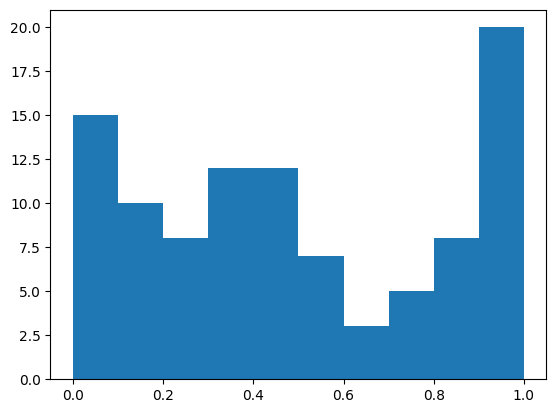

In [12]:
# creating the p-value data frame, plotting a histogram of said p-values and getting the smallest p-values in the data frame

pval_df = make_pval_df(pval_list)

plt.hist(pval_df['p-valeur'])

smallest_pv = [(-np.log10(pval_list[i][0]), pval_list[i][1]) for i in range(len(pval_list)) if -np.log10(pval_list[i][0]) > seuil]
print(len(smallest_pv))

In [13]:
pval_df

,p-valeur,moinslog10pvaleur,color
snarl index,,,
1>4,0.711884,0.147591,blue
4>9,0.396877,0.401344,blue
9>12,0.741182,0.130075,blue
12>14,0.180334,0.743923,blue
14>19,0.102512,0.989226,blue
...,...,...,...
489>492,1.0,-0.0,blue
492>497,0.027035,1.568072,blue
497>502,0.054222,1.265821,blue


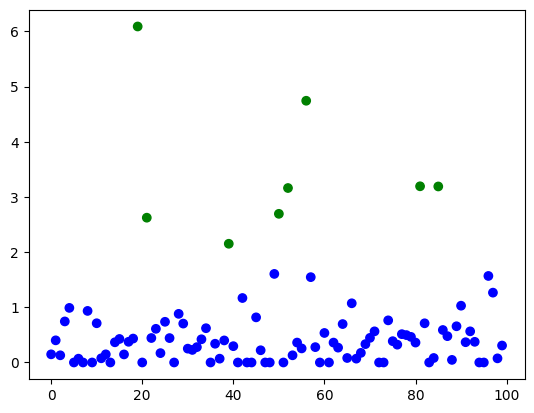

In [14]:
# manhattan plot

plt.scatter(range(len(pval_df)), pval_df['moinslog10pvaleur'], c=pval_df['color'])

In [15]:
# function to verify that the sum of the columns in the contingency tables is always 60 (because we have 60 vcf files)

def contingence_somme_col(snarl_list):
    snarl_index_somme_pas_ok = []
    for i in snarl_list:
        if make_table_contingence(all_df, g0_df, g1_df, i).sum(axis=0).iloc[0] != 60 or make_table_contingence(all_df, g0_df, g1_df, i).sum(axis=0).iloc[1] != 60:
            snarl_index_somme_pas_ok.append(i)

    if len(snarl_index_somme_pas_ok) == 0:
        print('bien ouej !')
    else:
        print('better luck next time...')


contingence_somme_col(all_df.index.unique())

bien ouej !


In [16]:
# size of all snarls and number of snarls for each size 
# ex: there are 66 snarls where only two paths are possible and 1 snarl with 61 possible paths

length_of_paths = []
for i in list(all_df.index):
    length_of_paths.append(list(all_df.index).count(i))

# occ = [[x,ind.count(x)] for x in set(ind)]

taille_chem = list(set(length_of_paths))
freq_taille = [len(list(group)) for key, group in groupby(sorted(length_of_paths))]
freq_taille = [int(freq_taille[i]/taille_chem[i]) for i in range(len(freq_taille))]

print(taille_chem, freq_taille)

[2, 3, 5, 7, 8, 9, 12, 13, 14, 16, 17, 61] [66, 19, 1, 2, 1, 2, 1, 1, 2, 3, 1, 1]


In [21]:
# generate a tsv file with the results of the tests

pval_df = pval_df.drop(columns='color')
pval_df.to_csv('pval_res', sep='\t', index=True, header=True)